# Image Classification using CNN

This Code Template is for Image Classification task using Convolutional Neural Network (ConvNet/CNN).

### Required Packages

In [1]:
import os
import numpy as np
from glob import glob
import itertools
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

# TensorFlow Modules
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# View an image
import matplotlib.pyplot as plt
import cv2
import random

### Initialization
Path of the main folder containing train and test folders

In [2]:
base_dir = os.path.dirname('')

Path of the train and test folders containing image files

In [3]:
train_dir = os.path.join(base_dir, 'train') #train
test_dir = os.path.join(base_dir, 'test') #test

List of target categories which are required for model training and predictions.

In [4]:
target = []

### Data Fetching

The OS module in Python provides functions for interacting with the operating system. This module provides a portable way of using operating system-dependent functionality.

OpenCV-Python is a library of Python bindings designed to solve computer vision problems.

We will use the <Code>os.path</Code> module to interact with the file system and the <Code>cv2.imread()</Code> method to load an image from the specified file path.

### Directory Structure
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>Master Directory</b>
 |__ <b>train</b>
    |______ <b>Class 1</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 2</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 3</b>: [1.jpg, 2.jpg, 3.jpg ....]
    :
    :
 |__ <b>test</b>
    |______ <b>Class 1</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 2</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 3</b>: [1.jpg, 2.jpg, 3.jpg ....]
    :
    :
</pre>

In [5]:
# useful for getting number of files
train_image_files = glob(train_dir + '/*/*.jp*g')
test_image_files = glob(test_dir + '/*/*.jp*g')

In [6]:
# Loading the image dataset and plotting some images from all target categories
def plot_image(data, target):
  count = 0
  for category in target:
      path=os.path.join(data, category)
      flg = 0
      ar = []
      # storing image paths in an array
      for img in os.listdir(path):
          ar.append(os.path.join(path,img)) 
          flg+= 1
          if flg==2:
            break
      # plotting the images in dataset
      plt.figure(figsize=(5,5))
      for i in range(2):
        d1 = ar[i]
        img_array = cv2.imread(d1,cv2.IMREAD_COLOR)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(1,2,i+1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis("off")
      count+= 1
      if count == len(target):
        break

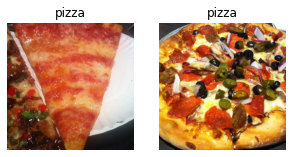

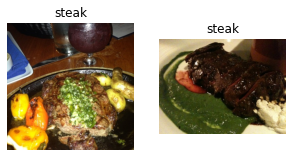

In [7]:
plot_image(train_dir,target)

### Data Preprocessing

An Image occupies a significant portion of space. Since images represent huge datasets, loading them at once to memory (RAM) can lead to severe scalibility issues and memory limitations. Therefore, in practice, images are loaded directly from the directory structure.   

TensorFlow 2 comes with a handy class called <Code>ImageDataGenerator</Code> that augments images. It takes the following parameters:

>**rotation_range**:	Int. Degree range for random rotations.

>**width_shift_range**: Float, 1-D array-like or int
  * float: fraction of total width, if < 1, or pixels if >= 1.
  * 1-D array-like: random elements from the array.
  * int: integer number of pixels from interval (-width_shift_range, +width_shift_range)
  * With width_shift_range=2 possible values are integers [-1, 0, +1], same as with width_shift_range=[-1, 0, +1], while with width_shift_range=1.0 possible values are floats in the interval [-1.0, +1.0).

>**height_shift_range**:	Float, 1-D array-like or int
  * float: fraction of total height, if < 1, or pixels if >= 1.
  * 1-D array-like: random elements from the array.
  * int: integer number of pixels from interval (-height_shift_range, +height_shift_range)
  * With height_shift_range=2 possible values are integers [-1, 0, +1], same as with height_shift_range=[-1, 0, +1], while with height_shift_range=1.0 possible values are floats in the interval [-1.0, +1.0).

>**brightness_range**:	Tuple or list of two floats. Range for picking a brightness shift value from.

>**zoom_range**:	Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
channel_shift_range	Float. Range for random channel shifts.

>**horizontal_flip**:	Boolean. Randomly flip inputs horizontally.

>**vertical_flip**:	Boolean. Randomly flip inputs vertically.

>**rescale**:	rescaling factor. Defaults to None. If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).

>**data_format**	Image data format, either "channels_first" or "channels_last". "channels_last" mode means that the images should have shape (samples, height, width, channels), "channels_first" mode means that the images should have shape (samples, channels, height, width). It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be "channels_last".

>**validation_split**:	Float. Fraction of images reserved for validation (strictly between 0 and 1).

For more information, refer to the [API](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#args)


In [8]:
rescale=1./255
rotation_range=20
width_shift_range=.15
height_shift_range=.15
horizontal_flip=True
zoom_range=0.2
data_format = "channels_last"

In [9]:
train_datagenerator = ImageDataGenerator(rescale = rescale,
                                         rotation_range = rotation_range,
                                         width_shift_range = width_shift_range,
                                         height_shift_range= height_shift_range,
                                         horizontal_flip = horizontal_flip,
                                         zoom_range = zoom_range,
                                         data_format = data_format)

test_datagenerator = ImageDataGenerator(rescale = rescale) #No need for augmentation for test dataset

### Flow From Directory

<Code>ImageDataGenerator</Code> class uses the method <Code>flow_from_directory</Code> to load the images. However, for this method to work, it is necessary the directory follow the above directory structure.

<Code>flow_from_directory</Code> takes the path to a directory & generates batches of augmented data. It takes following parameters:

>**directory**:	string, path to the target directory. It should contain one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images inside each of the subdirectories directory tree will be included in the generator. See this script for more details.

>**target_size**:	Tuple of integers (height, width), defaults to (256,256). The dimensions to which all images found will be resized.
color_mode	One of "grayscale", "rgb", "rgba". Default: "rgb". Whether the images will be converted to have 1, 3, or 4 channels.

>**classes**:	Optional list of class subdirectories (e.g. ['dogs', 'cats']). Default: None. If not provided, the list of classes will be automatically inferred from the subdirectory names/structure under directory, where each subdirectory will be treated as a different class (and the order of the classes, which will map to the label indices, will be alphanumeric). The dictionary containing the mapping from class names to class indices can be obtained via the attribute class_indices.

>**class_mode**:	One of "categorical", "binary", "sparse", "input", or None. Default: "categorical". Determines the type of label arrays that are returned:
  * "categorical" will be 2D one-hot encoded labels,
  * "binary" will be 1D binary labels,
  * "sparse" will be 1D integer labels,
  * "input" will be images identical to input images (mainly used to work with autoencoders).
  * If None, no labels are returned (the generator will only yield batches of image data, which is useful to use with model.predict()). Please note that in case of class_mode None, the data still needs to reside in a subdirectory of directory for it to work correctly.

>**batch_size**:	Size of the batches of data (default: 32).

>**shuffle**:	Whether to shuffle the data (default: True) If set to False, sorts the data in alphanumeric order.

For more information, refer to the [API](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)

In [10]:
batch_size = 64 # number of images to process at a time 
IMG_SHAPE = 224 # convert all images to be 224 x 224
class_mode = 'sparse' #type of problem (sparse, binary, or categorical, etc.)
shuffle = True #for training data

In [11]:
train_data = train_datagenerator.flow_from_directory(directory = train_dir,
                                               batch_size = batch_size, 
                                               target_size=(IMG_SHAPE, IMG_SHAPE), 
                                               classes = target,
                                               shuffle = shuffle,
                                               class_mode = class_mode)

test_data = test_datagenerator.flow_from_directory(directory = test_dir,
                                                    batch_size = batch_size,
                                                    target_size = (IMG_SHAPE, IMG_SHAPE),
                                                    classes = target,
                                                    shuffle = False,
                                                    class_mode = class_mode)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


### Model

In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of artificial neural network, most commonly applied to analyze visual imagery. They take advantage of the hierarchical pattern in data and assemble patterns of increasing complexity using smaller and simpler patterns embossed in their filters. Therefore, on a scale of connectivity and complexity, CNNs are on the lower extreme.

For more information, refer to this [article](https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939).

Following table lists typical layers used in a CNN. However, a CNN can also have other layers or lack one or more layer of the following:

| Layer | Description | Typical Parameters |
| --- | --- | --- |
| [Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input) | Input placeholder  with image shape | shape |
| [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) | Convolutional layer  | filters, kernel_size, padding, strides, activation |
| [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) | Pooling layer - used to reduce image size, typically follows a Covolution layer | pool_size, padding |
| [BatchNormalization](https://keras.io/api/layers/normalization_layers/batch_normalization/) | Normalization or scaling layer; typically follows Convolution layer  | axis, center, scale |
| [GlobalMaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D) | Pooling layer that reduces image size to unit  | data_format |
|[Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)| The Dropout layer randomly sets input units to 0 | rate |
| [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) | A densely-connected Neural Network  | units, activation |

### Model Tuning Parameters (Conv2d)
>**filters**:	Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).

>**kernel_size**:	An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.

>**strides**:	An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.

>**padding**:	one of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.

>**activation**:	Activation function to use. If you don't specify anything, no activation is applied

For more information on CNNs, refer to this [article](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

In [12]:
loss = "sparse_categorical_crossentropy" 
output_units = len(target)
output_activation = 'softmax'
learning_rate = 0.001
epochs = 10
NUM_COLOR_CHANNELS = 3

In [13]:
model = tf.keras.models.Sequential([
  Input(shape = (IMG_SHAPE, IMG_SHAPE,NUM_COLOR_CHANNELS)),
  Conv2D(filters=10, 
         kernel_size=3, 
         activation="relu"),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(pool_size=2, 
            padding="valid"), # padding can also be 'same'
  Conv2D(10, 3, activation="relu"),
  Conv2D(10, 3, activation="relu"),
  GlobalMaxPool2D(),
  Dense(output_units, activation=output_activation) 
])

# Compile the model
model.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=["accuracy"])

# Fit the model
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=test_data)

Epoch 1/10
24/24 [==============================] - 33s 1s/step - loss: 0.6884 - accuracy: 0.5633 - val_loss: 0.6804 - val_accuracy: 0.6740
Epoch 2/10
24/24 [==============================] - 29s 1s/step - loss: 0.6749 - accuracy: 0.6320 - val_loss: 0.6550 - val_accuracy: 0.6860
Epoch 3/10
24/24 [==============================] - 29s 1s/step - loss: 0.6502 - accuracy: 0.6427 - val_loss: 0.6244 - val_accuracy: 0.6740
Epoch 4/10
24/24 [==============================] - 29s 1s/step - loss: 0.6194 - accuracy: 0.6887 - val_loss: 0.6014 - val_accuracy: 0.6920
Epoch 5/10
24/24 [==============================] - 29s 1s/step - loss: 0.5910 - accuracy: 0.6920 - val_loss: 0.5788 - val_accuracy: 0.7020
Epoch 6/10
24/24 [==============================] - 28s 1s/step - loss: 0.5707 - accuracy: 0.7053 - val_loss: 0.5580 - val_accuracy: 0.7080
Epoch 7/10
24/24 [==============================] - 29s 1s/step - loss: 0.5506 - accuracy: 0.7253 - val_loss: 0.5341 - val_accuracy: 0.7440
Epoch 8/10
24/24 [==

### Plot Curves

Plot loss and accuracy metrics to see how the model trains

In [14]:
def plot_model(model_name_history, metric_name):
    # Plot loss per iteration
    fig, ax = plt.subplots(1, 2,figsize=(15,5))

    ax[0].plot(model_name_history.history['loss'], label='loss')
    ax[0].plot(model_name_history.history['val_loss'], label='val_loss')
    ax[0].legend()
    
    # Plot accuracy per iteration
    ax[1].plot(model_name_history.history[metric_name], label='accuracy')
    ax[1].plot(model_name_history.history[f"val_{metric_name}"], label='val_accuracy')
    ax[1].legend()

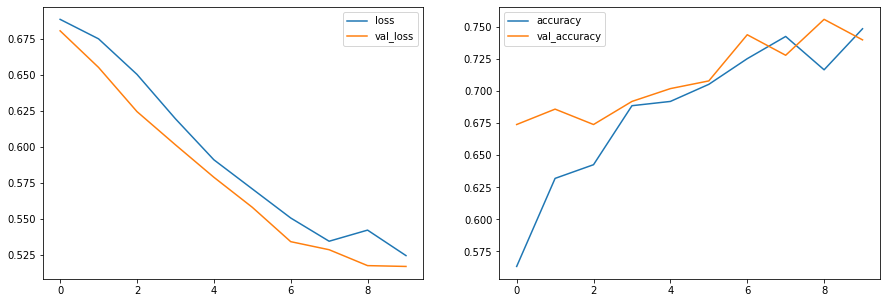

In [15]:
plot_model(history, 'accuracy')

### Model Evaluation (Accuracy)

In [16]:
predictions = model.predict(test_data)
y_pred = np.argmax(predictions,axis = 1)
y_test = test_data.classes
class_labels = list(test_data.class_indices.keys())   
loss, accuracy = model.evaluate(test_data)
print("Loss: ", loss)
print("Accuracy Score: ",accuracy)

8/8 [==============================] - 4s 437ms/step - loss: 0.5169 - accuracy: 0.7400
Loss:  0.5169287323951721
Accuracy Score:  0.7400000095367432


### Confusion Matrix

A confusion matrix is utilized to understand the performance of the classification model or algorithm in machine learning for a given test set where results are known.

In [17]:
def get_confusion_matrix(data, N):
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in data:
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    y_pred = np.argmax(p,axis = 1)
    predictions = np.concatenate((predictions, y_pred))
 
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break
  cm = confusion_matrix(targets, predictions)
  return cm

In [18]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  """

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Generating confusion matrix 500


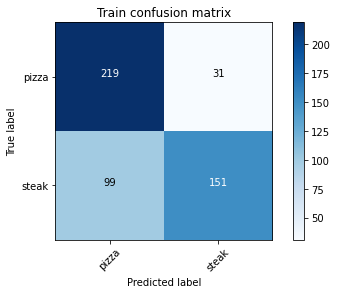

In [19]:
cm = get_confusion_matrix(test_data, len(test_image_files))
plot_confusion_matrix(cm, class_labels, title='Train confusion matrix')

#### Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True, how many are False.

* **where**:
    - Precision:- Accuracy of positive predictions.
    - Recall:- Fraction of positives that were correctly identified.
    - f1-score:-  percent of positive predictions were correct
    - support:- Support is the number of actual occurrences of the class in the specified dataset.

In [20]:
print(classification_report(y_test, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

       pizza       0.69      0.88      0.77       250
       steak       0.83      0.60      0.70       250

    accuracy                           0.74       500
   macro avg       0.76      0.74      0.74       500
weighted avg       0.76      0.74      0.74       500



#### Creator: Viraj Jayant, Github: [Profile](https://github.com/Viraj-Jayant/)